In [ ]:
%tensorflow_version 1.x 
!pip install keras==2.1.5

TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
! git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 39.49 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [ ]:
%cd Mask_RCNN
!python setup.py install

/content/Mask_RCNN
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:672: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
adding license file 'LICENSE' (mat

In [ ]:
pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages/mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 


In [ ]:
"""
Mask R-CNN
Train on the surgery robot dataset.
Copyright (c) 2018 Matterport, Inc.
Licensed under the MIT License (see LICENSE for details)
Written by Waleed Abdulla
"""

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

from mrcnn.config import Config
#import model as modellib
from mrcnn.utils import Dataset
 
class GarbageConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "garbage"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2   # Background + shoe + papercup

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    GPU_COUNT = 1

    BATCH_SIZE = GPU_COUNT * IMAGES_PER_GPU

############################################################
#  Dataset
############################################################

class GarbageDataset(Dataset):

    def load_garbage(self, dataset_dir, subset):
        """Load a subset of the papercup dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "shoe")
        self.add_class("dataset", 2, "paper cup")


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        annotations = json.load(open(os.path.join(annotations_dir, "annotations.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        
        # Add images
        count = 0
        for a in annotations:
            count = count+1

          
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            names =  [a['file_attributes']]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(images_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "dataset",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                names=names)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a garbage dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "dataset":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        class_names = info["names"]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Assign class_ids by reading class_names
        class_ids = np.zeros([len(info["polygons"])])
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        for i, p in enumerate(class_names):
        #"name" is the attributes name decided when labeling, etc. 'region_attributes': {name:'a'}
            if p['class_name'] == 'shoe':
                class_ids[i] = 1
            elif p['class_name'] == 'paper cup':
                class_ids[i] = 2
            #assert code here to extend to other labels
        class_ids = class_ids.astype(int)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #return mask, np.ones([mask.shape[-1]], dtype=np.int32)
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "dataset":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
import os
import urllib.request
link = 'https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5'
name = 'mask_rcnn_coco.h5'
urllib.request.urlretrieve(link, name)
#os.listdir()

('mask_rcnn_coco.h5', <http.client.HTTPMessage at 0x7f67b17f9350>)

Using TensorFlow backend.


['BG', 'shoe', 'paper cup']
(316, 475, 1)


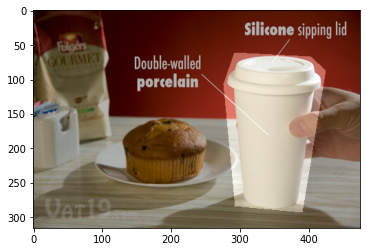

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import skimage.draw
from matplotlib import pyplot

# Training dataset.
dataset_train = GarbageDataset()
dataset_train.load_garbage("/content/drive/MyDrive/dataset", "train")
dataset_train.prepare()
print(dataset_train.class_names)

# load an image
image_id = 51
image = dataset_train.load_image(image_id)
#print(test_image.shape)
# load image mask
mask, class_ids = dataset_train.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
for j in range(mask.shape[2]):
  pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
pyplot.show()

In [ ]:
from mrcnn.model import MaskRCNN
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = GarbageDataset()
    dataset_train.load_garbage("/content/drive/MyDrive/dataset", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = GarbageDataset()
    dataset_val.load_garbage("/content/drive/MyDrive/dataset", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=5,
                layers='heads')
    
config = GarbageConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
#model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')
train(model)

Using TensorFlow backend.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








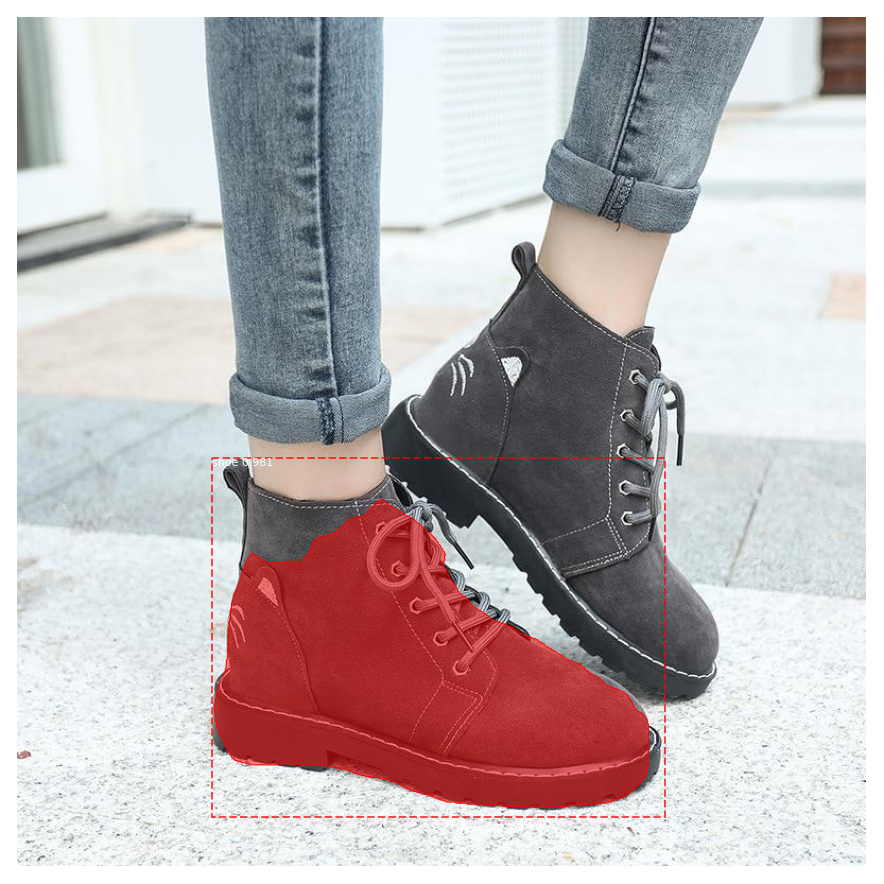

r  [[415 183 754 610]]


In [ ]:
from mrcnn.model import MaskRCNN
from mrcnn.config import Config
class GarbageConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "garbage"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2   # Background + shoe + papercup

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.90

    GPU_COUNT = 1

    BATCH_SIZE = GPU_COUNT * IMAGES_PER_GPU

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.visualize import display_instances
config = GarbageConfig()
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=config)
# load coco model weights
rcnn.load_weights('/content/drive/MyDrive/mask_rcnn_garbage_0005.h5', by_name=True)
# load photograph
img = load_img('/content/drive/MyDrive/dataset/train/images/shoe40.jpg')
img = img_to_array(img)
# make prediction
class_names = ['BG','shoe', 'paper cup']
results = rcnn.detect([img], verbose=0)
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
print("r ",   r['rois'])

In [ ]:
from mrcnn.model import MaskRCNN
from mrcnn.config import Config
class GarbageConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "garbage"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2   # Background + shoe + papercup

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.90

    GPU_COUNT = 1

    BATCH_SIZE = GPU_COUNT * IMAGES_PER_GPU

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.visualize import display_instances
config = GarbageConfig()
# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config = config)
# load coco model weights
rcnn.load_weights('/content/drive/MyDrive/mask_rcnn_garbage_0005.h5', by_name=True)

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes


# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }

    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
class_names = ['BG','shoe', 'paper cup']
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
    
    # grayscale image for face detection
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Run detection
    img = img_to_array(img)
    results = rcnn.detect([img], verbose=0)
    object_list = []
    class_name_list = []
    object_list = results[0]['rois'].tolist()
    class_name_list = results[0]['class_ids'].tolist()
    name = results[0]['class_ids']
    # get mask bounding box for overlay
    if len(object_list) != 0:
      
      for (x,y,w,h),c in zip(object_list , class_name_list):
        #print("r", results[0]['class_ids'])
        bbox_array = cv2.rectangle(bbox_array,(y,x),(h,w),(255,0,0),2)
        text = "{}: {:.4f}".format(class_names[c], results[0]['scores'][0])
        cv2.putText(bbox_array, text, (y, x - 5),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
      
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

MessageError: ignored